# BI-PRS - Semestral work 2

## Dataset selection according to the represant's data

In [56]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> ex0327, Life, P. Novák')

Parameter M = 2 => ex0327, Life, P. Novák

## Necessary imports

In [57]:
library(vcd)
library(dplyr)
library(DescTools)
library(Sleuth2)
library(ggplot2)
library(olsrr)
library(psych)
library(car)

## Data preparation

* Download the dataset.
* Explore, describe and modify the data if needed.

In [58]:
str(ex0327)
data <- ex0327
head(data, 5)

'data.frame':	29 obs. of  4 variables:
 $ Country: chr  "Australia" "Austria" "Belgium" "Canada" ...
 $ Life   : num  71 70.4 70.6 72 73.3 ...
 $ Income : num  3426 3350 3346 4751 5029 ...
 $ Type   : Factor w/ 2 levels "Industrialized",..: 1 1 1 1 1 1 1 1 1 1 ...


,Country,Life,Income,Type
,<chr>,<dbl>,<dbl>,<fct>
1,Australia,71.0,3426,Industrialized
2,Austria,70.4,3350,Industrialized
3,Belgium,70.6,3346,Industrialized
4,Canada,72.0,4751,Industrialized
5,Denmark,73.3,5029,Industrialized


The dataset contains data about life expectancy and *per capita income*\*  for $20$ *industrialized countries*\** and $9$ *petroleum exporting countries*\***. 

A data frame with $29$ observations on the following $4$ variables.
<br> `Country` : a character vector indicating the country
<br> `Life` : life expectancy
<br> `Income` : income in $1974$ (U.S. dollars)
<br> `Type` : factor variable with levels "Industrialized" and "Petroleum"
<br> [1]

\* - **Per capita income**: measures the average income earned per person in a given area (city, region, country, etc.) in a specified year. [2] 
<br> \** - **Industrialized countries**: Countries whose gross domestic product and exports contain a large share of industrial production. [3]
<br> \*** - **Petroleum exporting countries**: The writer probably has meant the countries of The Organization of the Petroleum Exporting Countries (OPEC) [4]

### Modifying the data
Due to the small number of regressors the additional one `Government` will be derived from the existing `Country`. This is a categorical feature that describes governance models of the countries provided. The feature has $3$ categories: `Parliamentary or constitutional monarchy`, `Republic`, `Authoritarian/one-party regimes`

In [59]:
data$Government <- c(1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3)
data$Government <- factor(
  data$Government, levels=c(1, 2, 3),
  labels=c('Parliamentary or constitutional monarchy', 'Republic', 'Authoritarian/one-party regimes'),)
head(data, 3)

,Country,Life,Income,Type,Government
,<chr>,<dbl>,<dbl>,<fct>,<fct>
1,Australia,71.0,3426,Industrialized,Parliamentary or constitutional monarchy
2,Austria,70.4,3350,Industrialized,Republic
3,Belgium,70.6,3346,Industrialized,Parliamentary or constitutional monarchy


### Data exploration

The following are summaries for both continuous and factor features.

In [60]:
continous_cols <- c('Life', 'Income')
factor_cols <- c('Type', 'Government')
describe(data[continous_cols], skew=F, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Life,29,64.800,11.09298,2.059915,19.70,52.3,70.6,72.00
Income,28,2765.179,1684.11408,318.267645,2547.75,1270.0,3151.0,3817.75


In [61]:
summary(data[factor_cols])

             Type                                       Government
 Industrialized:20   Parliamentary or constitutional monarchy: 9  
 Petroleum     : 9   Republic                                :10  
                     Authoritarian/one-party regimes         :10  

As it is mentioned in the original dataset description, the only `NaN` value is the income in South Africa. [1] For the purpose of training of models, the `clean_data` version of the dataset will be created.

In [62]:
clean_data <- data[!is.na(data$Income),]

### Data visualization

The following graph shows the visual difference in the life expectancy between `Industrialised` and `Petroleum` countries.

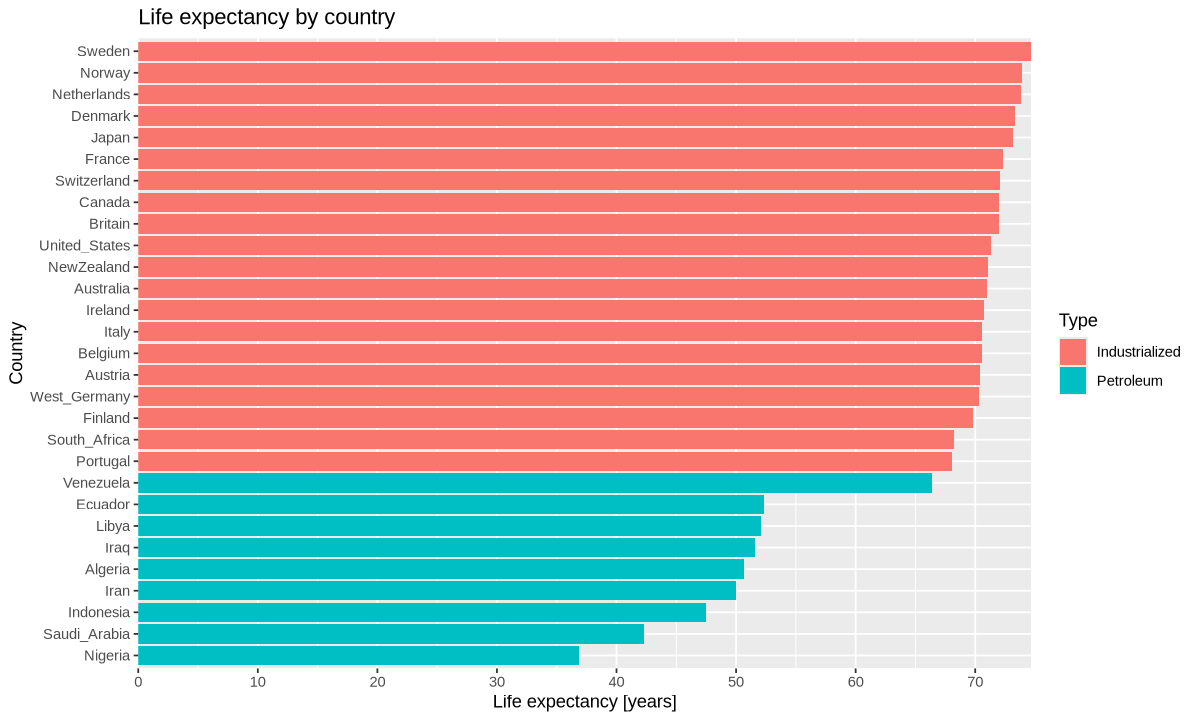

In [63]:
options(repr.plot.width=10, repr.plot.height=6) # set the size of a plot
ggplot(data, aes(x=Life, y=reorder(Country, Life), fill=Type)) +
    geom_bar(stat='identity') +
    labs(title='Life expectancy by country',
         x='Life expectancy [years]',
         y='Country') +
    scale_x_continuous(breaks=scales::pretty_breaks(n=10), expand=c(0, 0))

The obervation the draws the attention of a reader immediately is the difference in the expectation value of the variable `Life` between the types of the countries. We see that `Industrialised` countries have a dominative `Life expectancy` in comparison to `Petroleum` countries. To test the described heterogeneity an **ANOVA** is being conducted later in the work.

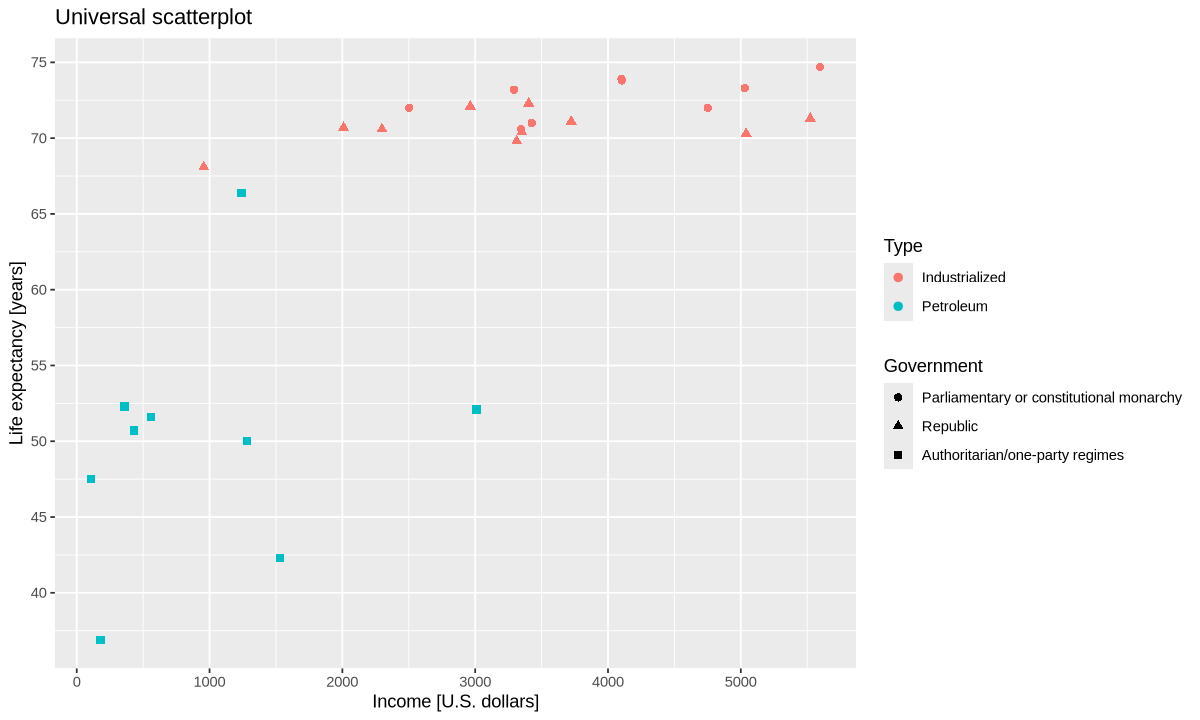

In [64]:
scatterplot <- ggplot(clean_data, aes(x=Income, y=Life, col=Type, shape=Government)) +
    geom_point(size=2) +
    labs(title='Universal scatterplot',
         x='Income [U.S. dollars]',
         y='Life expectancy [years]') +
    scale_y_continuous(breaks=scales::pretty_breaks(n=6)) +
    scale_x_continuous(breaks=scales::pretty_breaks(n=6)) 
scatterplot

The scatterplot placed above visualizes a few paramount insights hidden in data:
* `Petroleum` countries not only have a shorter `Life expectancy` on average but they also have a lower `Income` on average. Clusters are clearly observable.
* **All** petroleum countries are `Authoritarian/one-party regimes`.
* The difference between the other two forms of government is not so distinctive.

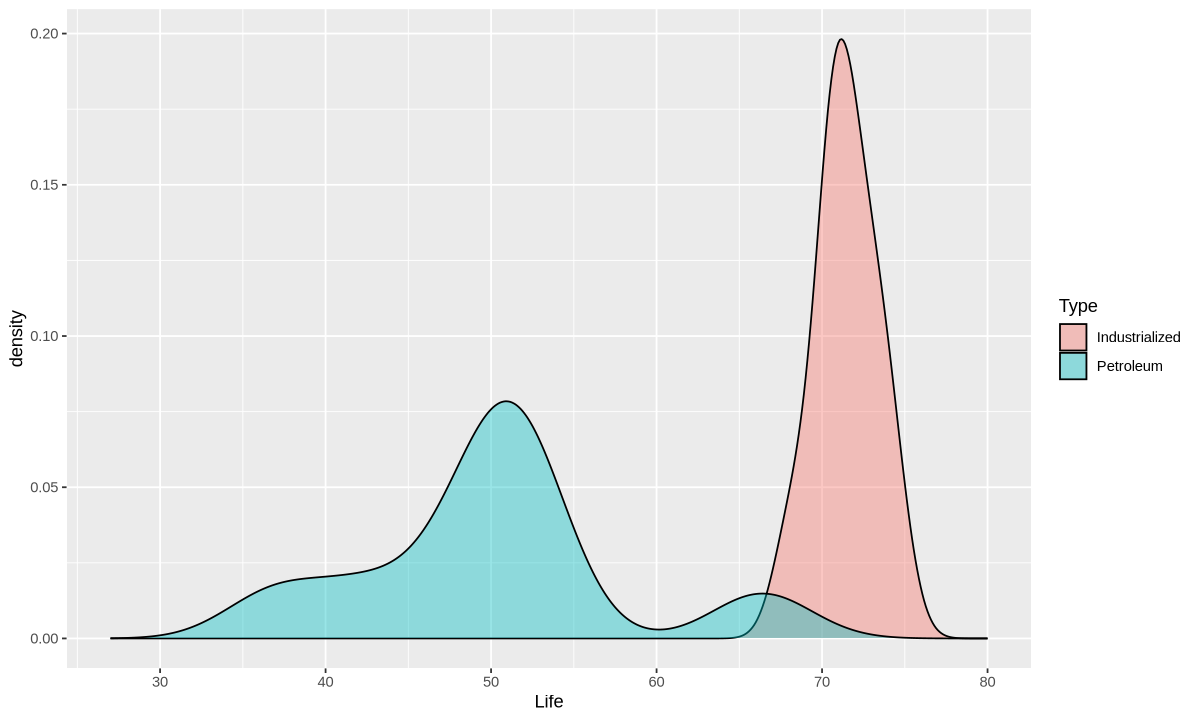

In [65]:
ggplot(data, aes(x=Life, fill=Type)) +
    geom_density(alpha=0.4, adjust=1.5) +
    scale_x_continuous(breaks=seq(30, 80, by=10), limits=c(27, 80))

The difference of the `Life expectancy` is being proven visually once more on the graph above.

### Analysis of a numerical regressor

The `Income` of a country is a selected categorical regressor. The $\log()$ transformation is applied to the regressor:
$$Y = \beta_0 + \beta_1 \cdot \log(X) + \varepsilon$$
$$\hat{Y} = b_0 + b_1 \cdot \log(X)$$

In [66]:
fit <- lm(Life ~ log(Income), clean_data)
summary(fit)


Call:
lm(formula = Life ~ log(Income), data = clean_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.279  -1.288   1.175   3.875   9.573 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.598      9.458  -0.063     0.95    
log(Income)    8.615      1.237   6.966 2.14e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.787 on 26 degrees of freedom
Multiple R-squared:  0.6512,	Adjusted R-squared:  0.6377 
F-statistic: 48.53 on 1 and 26 DF,  p-value: 2.137e-07


So we have $b_0 = -0.598, \ b_1 = 8.615$.\
Intercept was found to be statistically insignificant, while the logarithmic relationship was the opposite.\
The inerpretation of the coefficient $b_1$ is following:
- **Income** growth by $1$ percent will result in **Life** expectancy growth by $\frac{b_1}{100} \approx 0.09$ years

Now let's visualize the model.

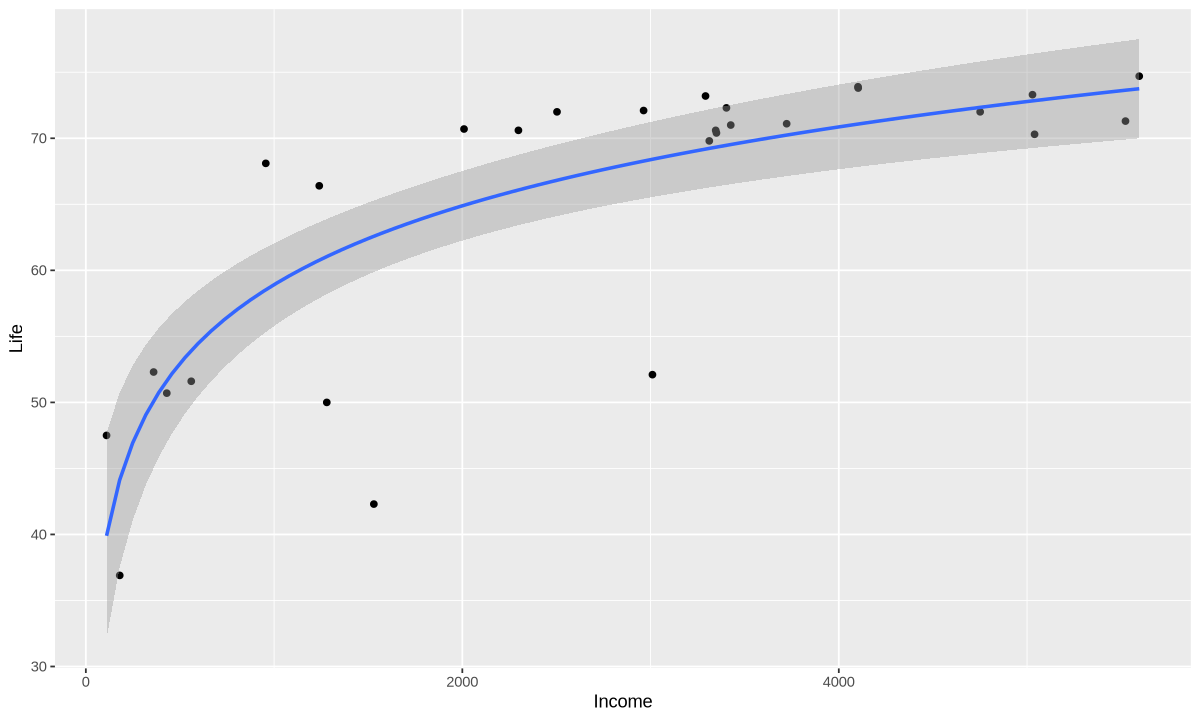

In [67]:
ggplot(clean_data, aes(x=Income, y=Life)) +
    geom_point() +
    geom_smooth(method='lm', formula=y ~ log(x))

As we can see, the logarithmic transformation is the most suitable one from the simplest for the given data.

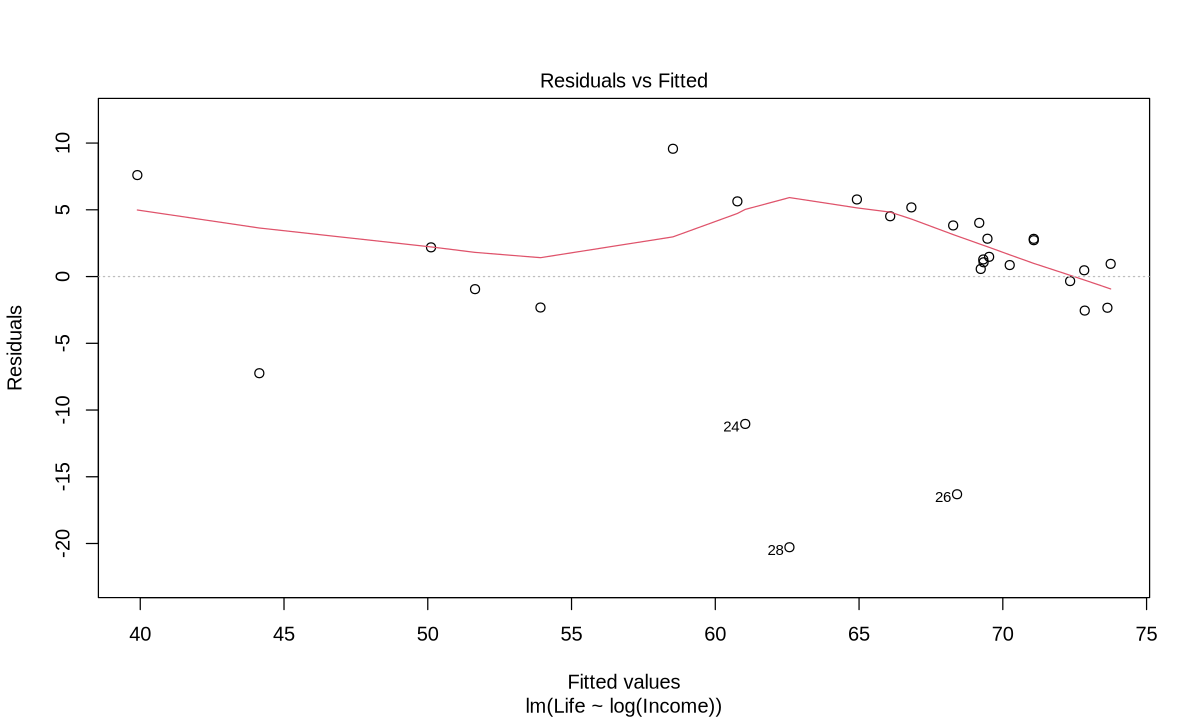

In [68]:
plot(fit, which=1)

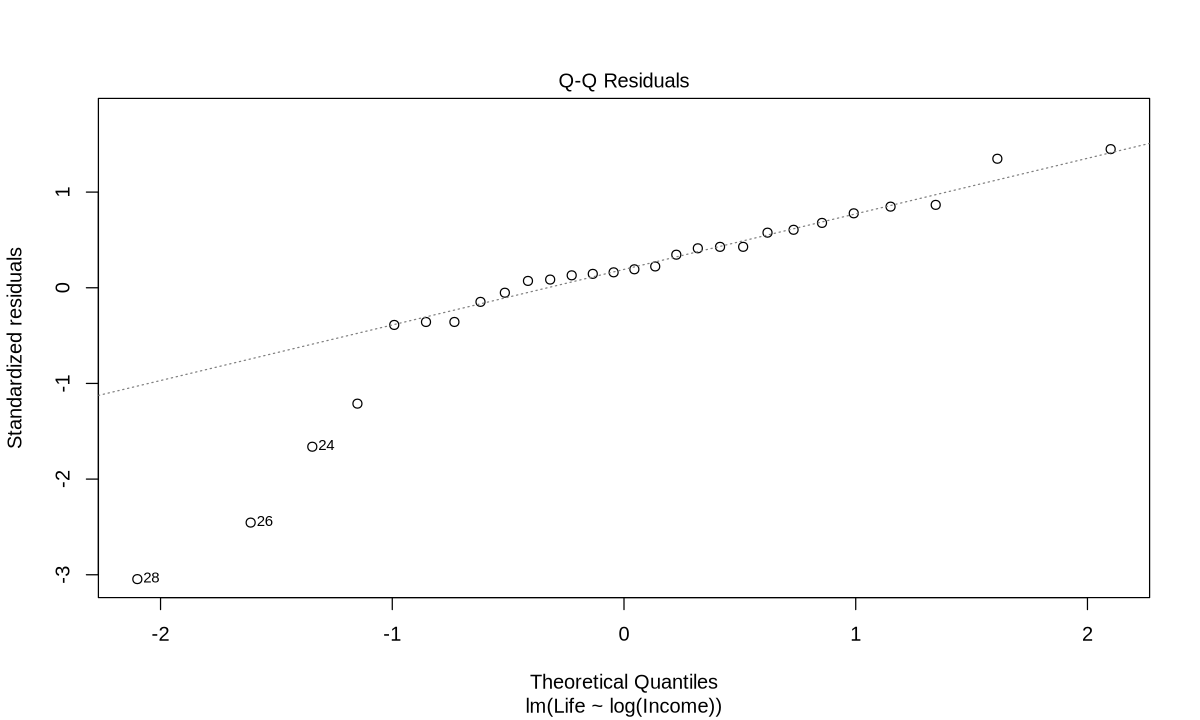

In [69]:
plot(fit, which=2)

On the other hand we can observe a problem with the distribution of residuals, which is caused by the presence of multiple outliers.

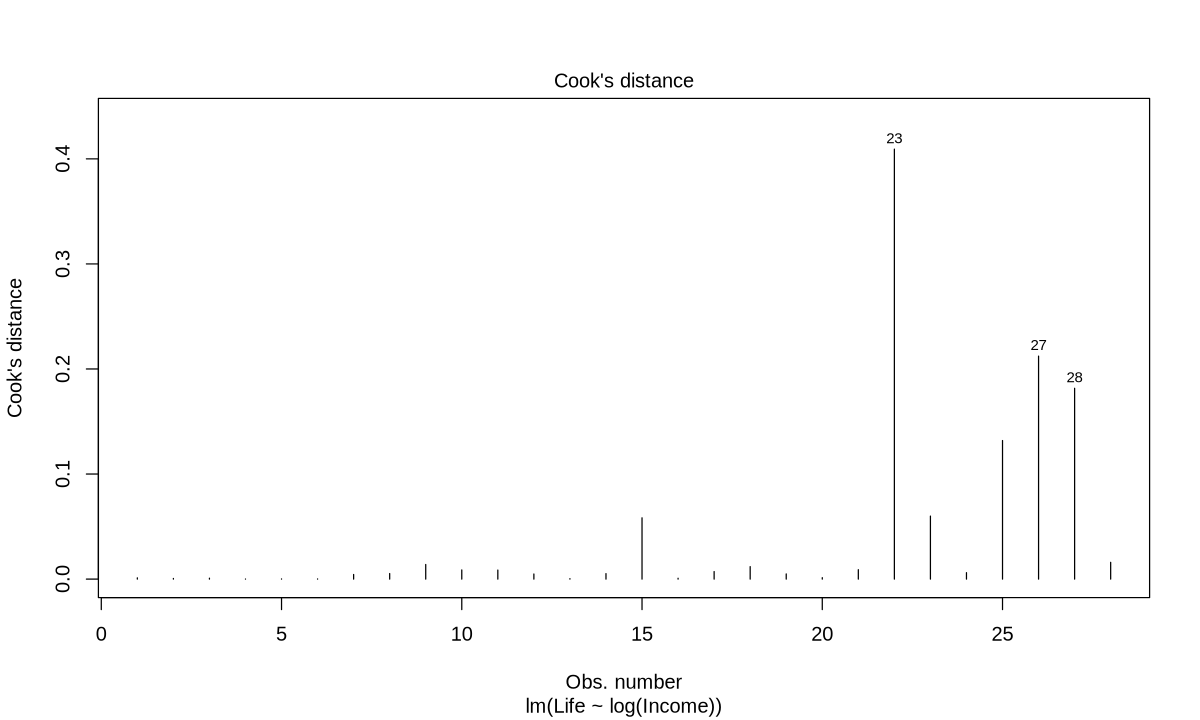

In [70]:
plot(fit, which=4)

According to Cook's distance $23$ element of the dataset has a greater impact on this problem.

### Analysis of a categorical regressor

The `Type` of a country is a selected categorical regressor.
<br> To analyse how this feature affects the target variable `life` the **ANOVA** is conducted.

$Industrialized
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  68.10   70.55   71.20   71.47   72.53   74.70 

$Petroleum
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  36.90   47.50   50.70   49.98   52.10   66.40 


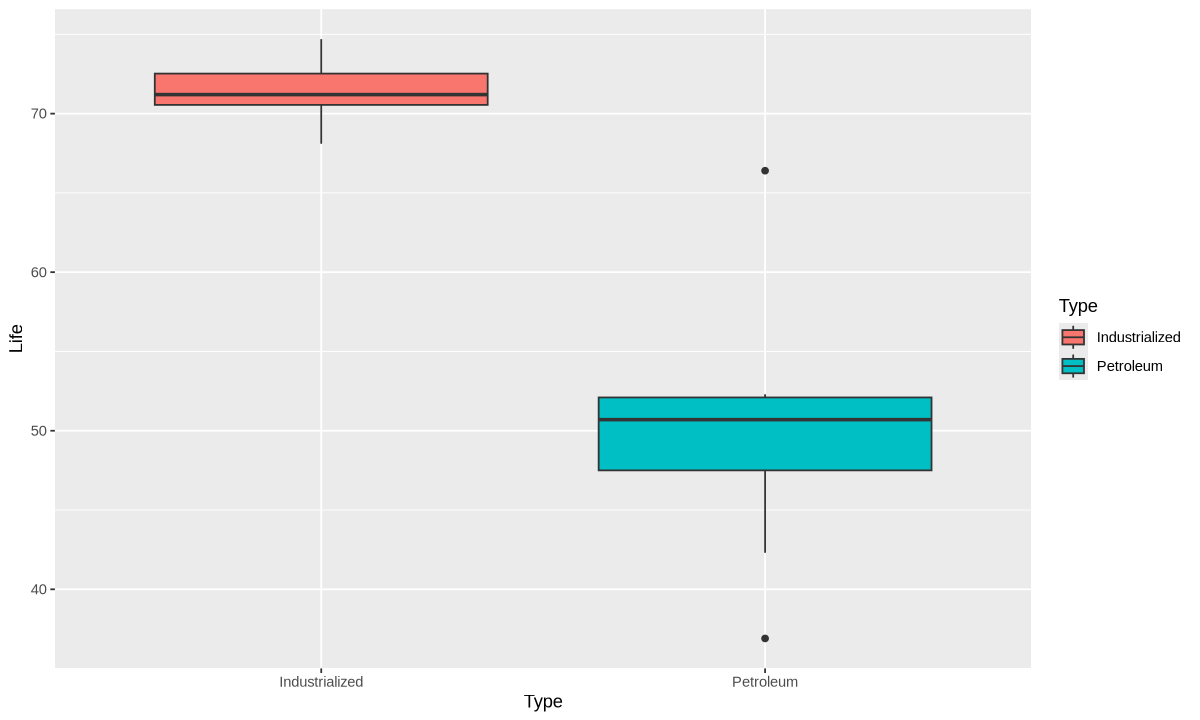

In [71]:
tapply(data$Life, data$Type, summary) # split the data$Life in groups by data$Type values and apply summary on it
ggplot(data, aes(x=Type, y=Life, fill=Type)) +
  geom_boxplot()

Using the `tapply` (tabulate apply) function the summary for the data of two categories was calculated. To make the difference in the **expected value** and the **variance** in the `Life expectancy` conditioned by the `Type` of a country even more visible, there is a boxplot placed above, which makes it obvious at a first glance. The intuition is tested below.

What is tested, formally:
<br>$𝐻_0: 𝜇_1 = 𝜇_2$
<br>$𝐻_𝐴: 𝜇_1 \ne 𝜇_2$

In [72]:
aov(Life~Type, data)

Call:
   aov(formula = Life ~ Type, data = data)

Terms:
                     Type Residuals
Sum of Squares  2867.0625  578.4576
Deg. of Freedom         1        27

Residual standard error: 4.628645
Estimated effects may be unbalanced

In [73]:
anova(aov(Life~Type, data))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Type,1,2867.0625,2867.06249,133.8226,5.713448e-12
Residuals,27,578.4576,21.42436,NA,NA


The `aov()` shows us which part of the variability is described by the difference in types. Using the **F-value** calculated by `anova()` we can **reject the hypothesis** of equality of expected values of `Life` amongst the `Industrialized` and `Petroleum` countries in favor of the alternative hypothesis.

In [74]:
fit = lm(data$Life~data$Type)
summary(fit)


Call:
lm(formula = data$Life ~ data$Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.0778  -1.0700   0.0222   1.7300  16.4222 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          71.470      1.035   69.05  < 2e-16 ***
data$TypePetroleum  -21.492      1.858  -11.57 5.71e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.629 on 27 degrees of freedom
Multiple R-squared:  0.8321,	Adjusted R-squared:  0.8259 
F-statistic: 133.8 on 1 and 27 DF,  p-value: 5.713e-12


Suprisingly, `Type` describes the target variable quite accurately, having the $R^2\ \mathrm{score} \approx 0.83$. We also see that the **t-test** of the nullity came out insignificant. That means that there's a significant difference of the mean values of `Life` amongst the categories.

We can interprete the results as following:
<br> ***"The average life expectancy in Petroleum countries is $21$ years less than the average life expectancy in Industrialized countries."***

### Analysis of both numerical and categorical regressor

In [75]:
summary(lm(data$Life~data$Type*data$Income))


Call:
lm(formula = data$Life ~ data$Type * data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.4145  -1.1530  -0.2627   1.6009  15.8443 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     6.887e+01  3.424e+00  20.115  < 2e-16 ***
data$TypePetroleum             -2.093e+01  4.135e+00  -5.062 3.55e-05 ***
data$Income                     7.673e-04  8.992e-04   0.853    0.402    
data$TypePetroleum:data$Income  1.347e-03  1.995e-03   0.675    0.506    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.658 on 24 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8483,	Adjusted R-squared:  0.8294 
F-statistic: 44.74 on 3 and 24 DF,  p-value: 5.545e-10


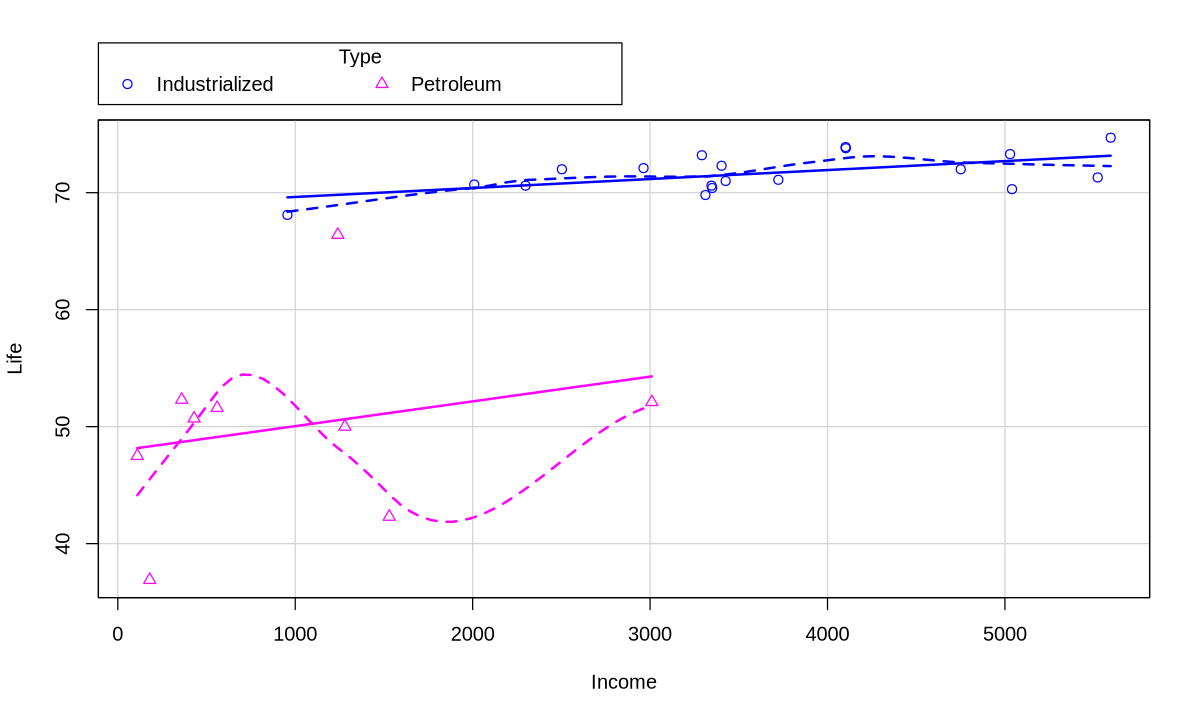

In [76]:
attach(clean_data)
scatterplot(Life ~ Income * Type)
detach(clean_data)

The key findings that need to be highlighted:
1. This is the best model at this very moment. $R^2 \approx 0.84$, which is a little better than the model dependent on a categorical feature only: $R^2 \approx 0.83$.
2. The `intercept` sets the average `life expectance` to $68.8$. If the country is `Petroleum`, the average declines immediately by $20.9$. The `Income` and `TypePetroleum:TypePetroleum` almost don't influence the target value. That is also backed by the **t-test** of nullity, which is significant. That means that these regressors can be removed without the drastic change in the prediction. (Cannot be removed at once, no info about that option.)

The following are attempts to remove the insignificant regressors one-by-one.

In [77]:
data_1hot <- cbind(data, model.matrix(~ Type - 1, data))
head(data_1hot, 3)

,Country,Life,Income,Type,Government,TypeIndustrialized,TypePetroleum
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,Australia,71.0,3426,Industrialized,Parliamentary or constitutional monarchy,1,0
2,Austria,70.4,3350,Industrialized,Republic,1,0
3,Belgium,70.6,3346,Industrialized,Parliamentary or constitutional monarchy,1,0


In [78]:
summary(lm(data$Life~data$Type + data_1hot$TypePetroleum:data$Income))


Call:
lm(formula = data$Life ~ data$Type + data_1hot$TypePetroleum:data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.4145  -1.0921  -0.4421   1.7077  15.8443 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          71.642106   1.062891  67.403  < 2e-16 ***
data$TypePetroleum                  -23.708203   2.539163  -9.337 1.26e-09 ***
data_1hot$TypePetroleum:data$Income   0.002114   0.001772   1.194    0.244    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.633 on 25 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8437,	Adjusted R-squared:  0.8312 
F-statistic: 67.48 on 2 and 25 DF,  p-value: 8.397e-11


In [79]:
summary(lm(data$Life~data$Type + data$Income))


Call:
lm(formula = data$Life ~ data$Type + data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.2590  -0.8578   0.0919   1.3400  16.1377 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         67.877253   3.060170  22.181  < 2e-16 ***
data$TypePetroleum -18.905628   2.811449  -6.725 4.78e-07 ***
data$Income          0.001041   0.000794   1.311    0.202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.607 on 25 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8454,	Adjusted R-squared:  0.8331 
F-statistic: 68.37 on 2 and 25 DF,  p-value: 7.311e-11


In both cases, the other regressor left is also insignificant. By removing the last insignificant regressor, in both cases we find ourselves having only one initial regressor `Type`. The behaviour of this model is shown above in the "Analysis of a categorical regressor" section.

### Analysis with adding one more regressor to the model

We will add one more regressor to a linear model - `Government`. 

First of all, we will analyze how government by itself affects the target variable `Life`. For this we will use **ANOVA**.

In [80]:
attach(clean_data)

$`Parliamentary or constitutional monarchy`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  70.60   72.00   73.20   72.72   73.80   74.70 

$Republic
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  68.10   70.33   70.65   70.67   71.25   72.30 

$`Authoritarian/one-party regimes`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  36.90   47.50   50.70   49.98   52.10   66.40 


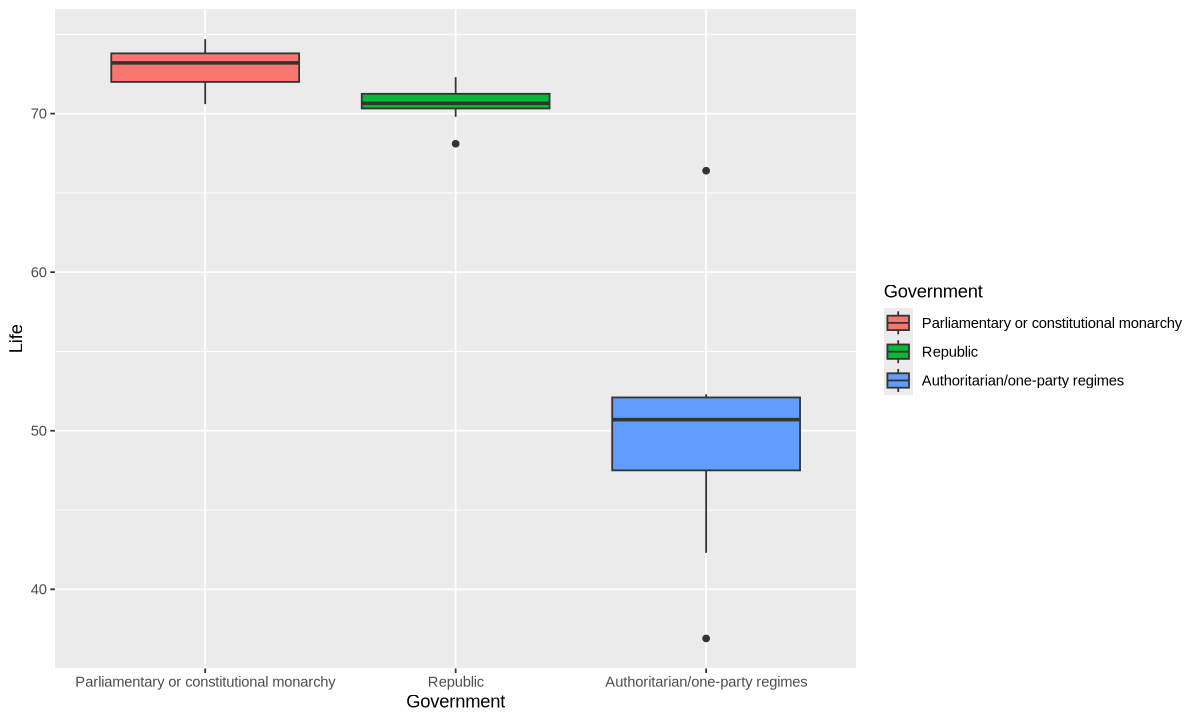

In [81]:
tapply(Life, Government, summary) # split the data$Life in groups by data$Type values and apply summary on it
ggplot(clean_data, aes(x=Government, y=Life, fill=Government)) +
  geom_boxplot()

There is some dependency of life expectancy on government type, though between parlamentary or constitutional monarchy and republic the difference is not so significant. We can already guess that the **ANOVA** test will reject null hypothesis of equal means across each factor:

- $H_0$: $\mu_1 = \mu_2=\mu_3$
- $H_A$: $\exists{i\neq j}: \mu_i\neq \mu_j.$

In [82]:
aov(Life~Government)

Call:
   aov(formula = Life ~ Government)

Terms:
                Government Residuals
Sum of Squares   2886.2951  547.2521
Deg. of Freedom          2        25

Residual standard error: 4.678684
Estimated effects may be unbalanced

In [83]:
anova(aov(Life~Government))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Government,2,2886.2951,1443.14755,65.927,1.072891e-10
Residuals,25,547.2521,21.89009,NA,NA


p-value $\lt 0.05$, thus we reject null hypothesis in preference of alternative, that there exists some factor which has mean value different from mean values of other factors.

We will try to train linear model with all possible interactions between each variable. We will also use log function on `Income`. With interactions we will have $16$ features. This is too much, but we will apply different methods later to reduce this number.

In [84]:
fit_all <- lm(Life ~ log(Income) * Income * Type * Government, clean_data)
summary(fit_all)


Call:
lm(formula = Life ~ log(Income) * Income * Type * Government, 
    data = clean_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6110  -0.7367   0.0846   1.1306  13.3807 

Coefficients: (12 not defined because of singularities)
                                                                             Estimate
(Intercept)                                                                 3.008e+02
log(Income)                                                                -3.625e+01
Income                                                                      8.465e-02
TypePetroleum                                                              -2.970e+02
GovernmentRepublic                                                         -3.188e+02
GovernmentAuthoritarian/one-party regimes                                          NA
log(Income):Income                                                         -8.022e-03
log(Income):TypePetroleum                                 

$R^2 \approx 0.875$, this is the best score, but the model is too complex and overfitted, adjusted $R^2 \approx 0.7897$ is worse than in the previous model.

F-statistics shows that we reject hypothesis that all coefficients are $0$ and are insignificant.

It is important that $12$ coefficients are not defined because of singularities. There may be two reasons of that: multicollinearity or lack of data points.

Warning message in predict.lm(fit_all, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


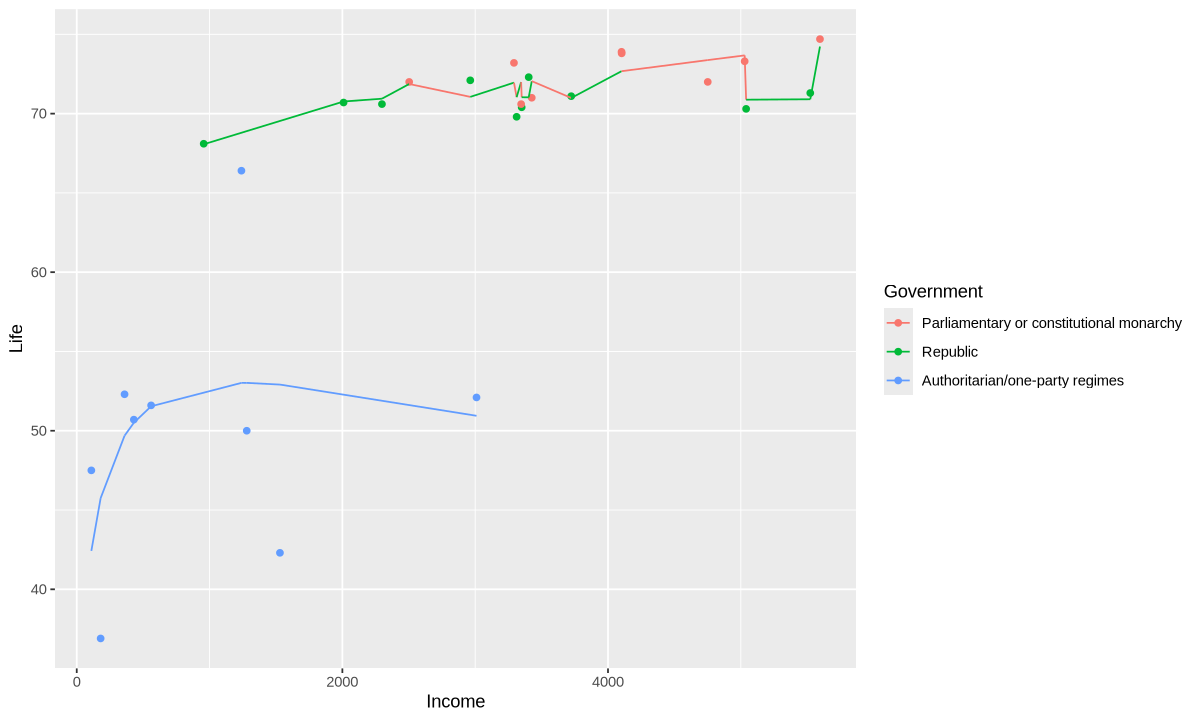

In [85]:
tmp <- predict(fit_all, interval="prediction")
df.inter <- cbind(clean_data, tmp)
ggplot(df.inter, aes(x=Income, y=Life, group=Type, color=Government)) +
    geom_point() +
    geom_line(aes(y=fit))

Our model is very complex and is clearly overfitted, we need to simplify it. For this we will use different methods to find out, which regressors or their interactions are insignificant and can be removed.

We will start with inspecting the problem with undefined coefficients:

In [86]:
addmargins(table(Government, Type))

,Industrialized,Petroleum,Sum
Parliamentary or constitutional monarchy,9,0,9
Republic,10,0,10
Authoritarian/one-party regimes,0,9,9
Sum,19,9,28


For some interactions between `Government` and `Type` there is no datapoints. This caused the problem with undefined coefficients.

We will now try model with less interactions - for example interaction `Government*Type` doesn't have enough datapoints, so we will remove this inetraction. Also iteraction between `Income` and its transformed version `log(Income)` also seems to be redundant, p-value is the highest for this interaction.

In [87]:
fit_all_simplified <- lm(Life ~ Income * Type  + Income * Government + log(Income) * Type + log(Income) * Government, clean_data)
summary(fit_all_simplified)


Call:
lm(formula = Life ~ Income * Type + Income * Government + log(Income) * 
    Type + log(Income) * Government, data = clean_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.9618  -0.8448   0.2276   1.1437  13.1374 

Coefficients: (3 not defined because of singularities)
                                                        Estimate Std. Error
(Intercept)                                            1.136e+02  3.911e+02
Income                                                 2.405e-03  1.382e-02
TypePetroleum                                         -1.009e+02  3.916e+02
GovernmentRepublic                                    -7.771e+01  3.981e+02
GovernmentAuthoritarian/one-party regimes                     NA         NA
log(Income)                                           -6.105e+00  5.394e+01
Income:TypePetroleum                                  -7.137e-03  1.444e-02
Income:GovernmentRepublic                             -3.742e-03  1.440e-02
Income:GovernmentAut

$R^2 \approx 0.875$ is the same, but adjusted $R^2 \approx 0.8224$ is much better than in the previous model.

Warning message in predict.lm(fit_all_simplified, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


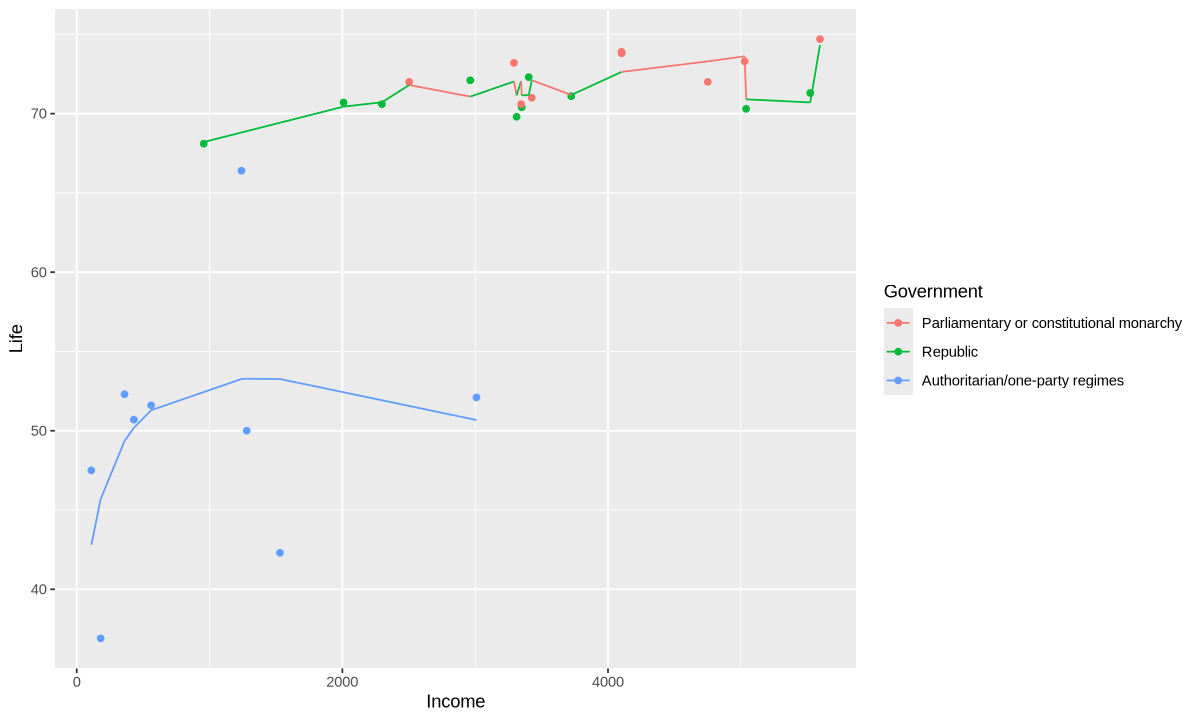

In [88]:
tmp <- predict(fit_all_simplified, interval="prediction")
df.inter <- cbind(clean_data, tmp)
ggplot(df.inter, aes(x=Income, y=Life, group=Type, color=Government)) +
    geom_point() +
    geom_line(aes(y=fit))

Though the model is more simple, still it may be overfitted. 

Again, we have undefined coeficients. We will inspect if we have multicollinearity issues.

In [89]:
select(clean_data, Type, Government)

,Type,Government
,<fct>,<fct>
1,Industrialized,Parliamentary or constitutional monarchy
2,Industrialized,Republic
3,Industrialized,Parliamentary or constitutional monarchy
4,Industrialized,Parliamentary or constitutional monarchy
5,Industrialized,Parliamentary or constitutional monarchy
6,Industrialized,Republic
7,Industrialized,Republic
8,Industrialized,Republic
9,Industrialized,Republic


We see that all `Petroleum` countries are with `Authoritarian/one-party regimes`. `Industrialized` countries though have more subtle splitting into `Republic` and `Parliamentary or constitutional monarchy`. This means that `Government` feature contain all information the `Type` feature has, but also has some additional information about countries in industrialized group. 

In [90]:
fit_gt = lm(Life~Government + Type)
summary(fit_gt)


Call:
lm(formula = Life ~ Government + Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.0778  -0.7592   0.2300   1.2408  16.4222 

Coefficients: (1 not defined because of singularities)
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 72.722      1.560  46.630  < 2e-16
GovernmentRepublic                          -2.052      2.150  -0.955    0.349
GovernmentAuthoritarian/one-party regimes  -22.744      2.206 -10.312 1.72e-10
TypePetroleum                                   NA         NA      NA       NA
                                             
(Intercept)                               ***
GovernmentRepublic                           
GovernmentAuthoritarian/one-party regimes ***
TypePetroleum                                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.679 on 25 degrees of freedom
Multiple R-squared:  0.8406,	Adjusted R-squar

Even without interactions between `Type` and `Government` we have problems with coefficients. We will use VIF method to check multicollinearity between `Type` and `Government`.

In [91]:
try({
    vif(fit_gt)
    })

Error in vif.default(fit_gt) : 
  there are aliased coefficients in the model


The error above indicates that there is strong multicollinearity between `Government` and `Type` regressors.

The **assocstats()** function will calculate Chi-square tests of independence, Cramer's V coefficient, which shows the measure of association between these two regressors.

In [92]:
table_data <- table(Government, Type)
addmargins(table_data)

,Industrialized,Petroleum,Sum
Parliamentary or constitutional monarchy,9,0,9
Republic,10,0,10
Authoritarian/one-party regimes,0,9,9
Sum,19,9,28


In [93]:
astats <- assocstats(table_data)
astats

                    X^2 df   P(> X^2)
Likelihood Ratio 35.165  2 2.3125e-08
Pearson          28.000  2 8.3153e-07

Phi-Coefficient   : NA 
Contingency Coeff.: 0.707 
Cramer's V        : 1 

Two chi-square tests of independence were conducted with different approaches.

p-values indicate rejection of null hypothesis of independence between `Type` and `Government`. Contingency coefficient is $0.707$, which shows us that there is strong association between these two regressors. The Cramer's V has its maximum value $1$, which means perfect association.

This all means, that we cannot use `Type` and `Government` regressors together. Thus, to choose the final model, we need to choose between these two regressors and test which one describes our target variable better.

For this we will train two linear models - one with `Government` regressor and the other with `Type` regressor and conduct anova to test if difference of residuals between the models is significant.

In [104]:
fit_all_simplified_summary = summary(fit_all_simplified)
print(paste("Government and Type model R-squared: ", round(fit_all_simplified_summary$r.squared, 3)))
print(paste("Government and Type model adjusted R-squared: ", round(fit_all_simplified_summary$adj.r.squared, 3)))

fit_ig = lm(Life ~ Income * Government + log(Income) * Government)
fig_ig_summary = summary(fit_ig)
print(paste("Government model R-squared: ", round(fig_ig_summary$r.squared, 3)))
print(paste("Government model adjusted R-squared: ", round(fig_ig_summary$adj.r.squared, 3)))

fit_it = lm(Life ~ Income * Type + log(Income) * Type)
fig_it_summary = summary(fit_it)
print(paste("Type model R-squared: ", round(fig_it_summary$r.squared, 3)))
print(paste("Type model adjusted R-squared: ", round(fig_it_summary$adj.r.squared, 3)))

[1] "Government and Type model R-squared:  0.875"
[1] "Government and Type model adjusted R-squared:  0.822"
[1] "Government model R-squared:  0.875"
[1] "Government model adjusted R-squared:  0.822"
[1] "Type model R-squared:  0.871"
[1] "Type model adjusted R-squared:  0.842"


It is very interesting, how R-squared value didn't change after removing of `Type` feature from the model.

In [103]:
anova(fit_all_simplified, fit_it)
anova(fit_all_simplified, fit_ig)
anova(fit_it, fit_ig)
anova(fit_it, fit_ig, fit_all_simplified)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19,429.0246,NA,NA,NA,NA
2,22,443.2951,-3,-14.2705,0.2106634,0.8877563


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19,429.0246,NA,NA,NA,NA
2,19,429.0246,0,1.705303e-13,NA,NA


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,22,443.2951,NA,NA,NA,NA
2,19,429.0246,3,14.2705,0.2106634,0.8877563


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,22,443.2951,NA,NA,NA,NA
2,19,429.0246,3,1.427050e+01,0.2106634,0.8877563
3,19,429.0246,0,-1.705303e-13,NA,NA


We see that according to p value there is no significant difference between those two models.

Currently, the model is with `Type` feature, because it has much higher adjusted R-squared. This is interesting, because additional information from `Government` feature doesn't improve model quality very much, but increases its complexity more significantly. 

The diffirence between models is not significant. We will continue with model which has `Type` feature as our new baseline and try to improve it. 

In [105]:
fig_it_summary


Call:
lm(formula = Life ~ Income * Type + log(Income) * Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.9618  -1.1617   0.2855   1.4507  13.1374 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                4.492e+01  6.149e+01   0.731    0.473
Income                    -3.629e-04  3.025e-03  -0.120    0.906
TypePetroleum             -3.227e+01  6.421e+01  -0.503    0.620
log(Income)                3.451e+00  8.848e+00   0.390    0.700
Income:TypePetroleum      -4.369e-03  4.978e-03  -0.878    0.390
TypePetroleum:log(Income)  3.075e+00  9.477e+00   0.324    0.749

Residual standard error: 4.489 on 22 degrees of freedom
Multiple R-squared:  0.8709,	Adjusted R-squared:  0.8416 
F-statistic: 29.68 on 5 and 22 DF,  p-value: 4.434e-09


Though all coefficients are defined, the model still can be simplified. We will try to iteratively drop each regressor to see how model will improve.

In [106]:
drop1(lm(Life~Income + log(Income) + Type),test="F")

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,466.7886,86.78281,NA,NA
Income,1,6.102103,472.8907,85.14647,0.3137405,0.5805851383
log(Income),1,63.929057,530.7176,88.37672,3.2869214,0.0823612479
Type,1,722.610700,1189.3993,110.97198,37.1531299,0.0000026965


The Akaike Information Criterion (AIC) value shows us how with dropping of certain regressor the meausure of how well the model describes the data changes. 

We see that with dropping of `Income` regressor, the AIC value decreased, which means that with addition of this regressor the model will describe the data worse. Obviously the `Income` regressor should be removed.

In [107]:
fit_lig = lm(Life ~ log(Income) * Type)
summary(fit_lig)


Call:
lm(formula = Life ~ log(Income) * Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.2904  -1.3034   0.1065   1.6984  14.4118 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)  
(Intercept)                51.8730    20.3781   2.546   0.0178 *
log(Income)                 2.4334     2.5052   0.971   0.3411  
TypePetroleum             -20.2953    22.4710  -0.903   0.3754  
log(Income):TypePetroleum   0.4321     2.8979   0.149   0.8827  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.437 on 24 degrees of freedom
Multiple R-squared:  0.8624,	Adjusted R-squared:  0.8452 
F-statistic: 50.14 on 3 and 24 DF,  p-value: 1.734e-10


Not all coefficients are statistically significant. The highest p-value has the `log(Income):TypePetroleum` coefficient, meaning this coefficient is the most insignificant among the other coefficients. We will remove the `log(Income):TypePetroleum` coefficient and see how our model will change.

In [109]:
fit_final = lm(Life ~ log(Income) + Type)
summary(fit_final)


Call:
lm(formula = Life ~ log(Income) + Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1909  -1.3414   0.2523   1.6357  14.4884 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     49.250     10.078   4.887 5.00e-05 ***
log(Income)      2.756      1.234   2.233   0.0347 *  
TypePetroleum  -16.971      2.741  -6.191 1.79e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.349 on 25 degrees of freedom
Multiple R-squared:  0.8623,	Adjusted R-squared:  0.8513 
F-statistic: 78.26 on 2 and 25 DF,  p-value: 1.729e-11


All coefficients are statistically significant, so this will be our final model.

Final model interpretation:

$b_0 = 49.250, \ b_1 = 2.756, \ b_2 = -16.971$:
- Bias is $\approx 49$ years, that means that if other variables will be $0$, playing no role in prediction, life expectancy will be $49$ years by default.
- `Income` growth by $1$ percent will result in `Life` expectancy growth by $\frac{b_1}{100} \approx 0.03$ years.
- If state has the `Type` = `Petroleum`, life expectancy will be dropped by $\approx 17$ years.

Warning message in predict.lm(fit_final, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


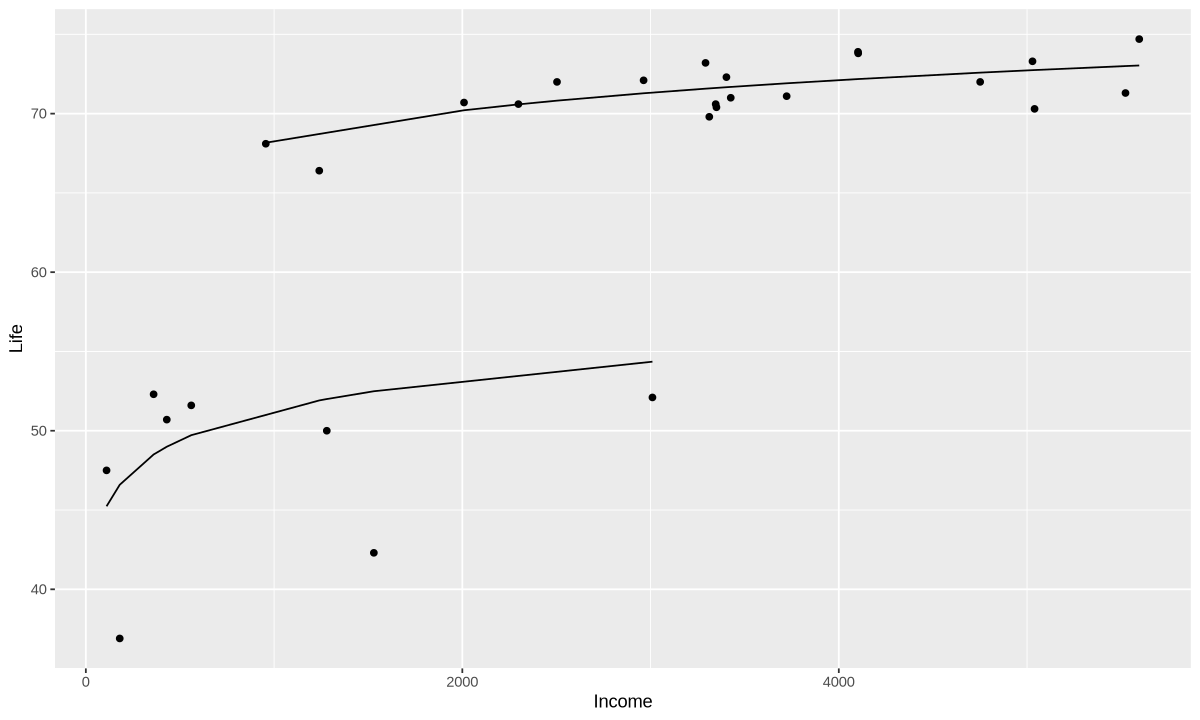

In [115]:
tmp <- predict(fit_final, interval="prediction")
df.inter <- cbind(clean_data, tmp)
ggplot(df.inter, aes(x=Income, y=Life, group=Type)) +
    geom_point() +
    geom_line(aes(y=fit))

It is worth saying, that the same results can be obtained by using `Government` feature instead of `Type`. If we will convert it to one-hot representation and use feature that determines if country has `Authoritarian/one-party regimes` government type, then we will get same column it is numerical representation as `Type` column.

For the sake of curiousty, let's demonstrate this:

In [116]:
clean_data_gov1hot <- cbind(clean_data, model.matrix(~ Government - 1, clean_data))
fit_final_alternative = lm(formula = Life ~ log(Income) + `GovernmentAuthoritarian/one-party regimes`, data=clean_data_gov1hot)
summary(fit_final_alternative)


Call:
lm(formula = Life ~ log(Income) + `GovernmentAuthoritarian/one-party regimes`, 
    data = clean_data_gov1hot)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1909  -1.3414   0.2523   1.6357  14.4884 

Coefficients:
                                            Estimate Std. Error t value
(Intercept)                                   49.250     10.078   4.887
log(Income)                                    2.756      1.234   2.233
`GovernmentAuthoritarian/one-party regimes`  -16.971      2.741  -6.191
                                            Pr(>|t|)    
(Intercept)                                 5.00e-05 ***
log(Income)                                   0.0347 *  
`GovernmentAuthoritarian/one-party regimes` 1.79e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.349 on 25 degrees of freedom
Multiple R-squared:  0.8623,	Adjusted R-squared:  0.8513 
F-statistic: 78.26 on 2 and 25 DF,  p-value: 1.729e-11


Warning message in predict.lm(fit_final_alternative, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


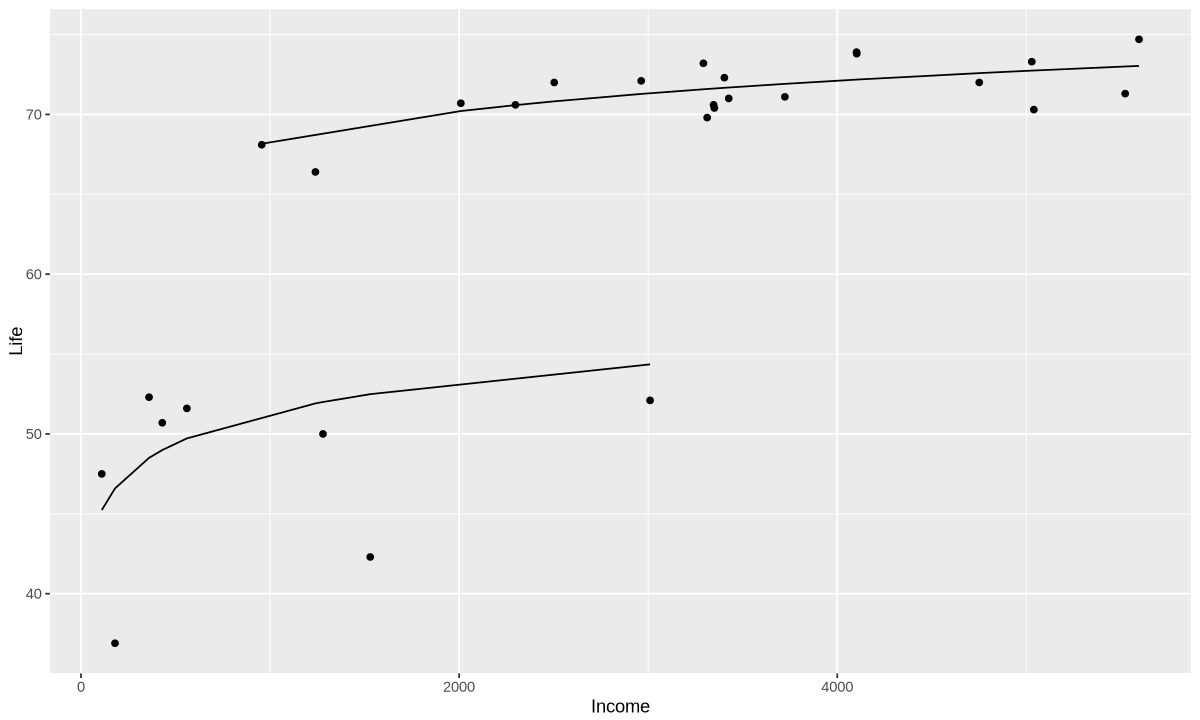

In [117]:
tmp <- predict(fit_final_alternative, interval="prediction")
df.inter <- cbind(clean_data_gov1hot, tmp)
ggplot(df.inter, aes(x=Income, y=Life, group=`GovernmentAuthoritarian/one-party regimes`)) +
    geom_point() +
    geom_line(aes(y=fit))

### Vefifying of assumptions of used methods

Some methods, like anova or t-tests expect normality of data, in case of linear models they expect normality of residuals.

We will look at normality of residuals of our model:

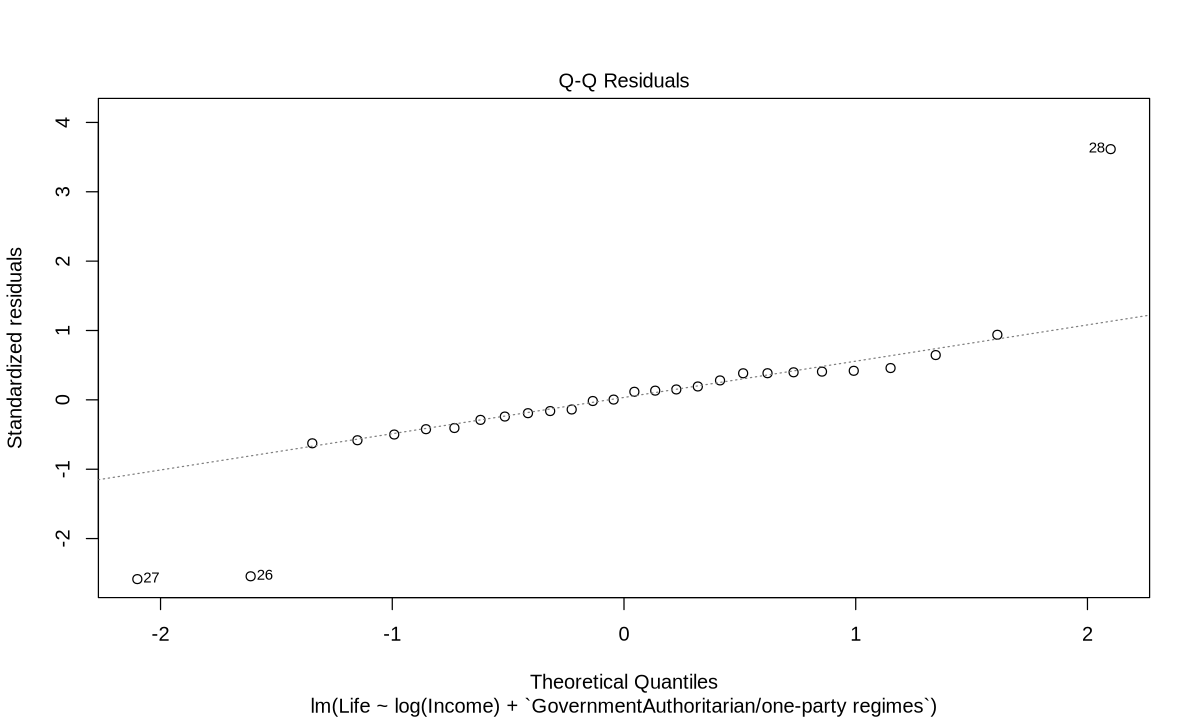

In [49]:
plot(fit_final, which=2)

We have $3$ strong outliers there, but the rest of residuals shows normality. We will conduct tests of normality:

In [50]:
ols_test_normality(fit_final)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.7907          1e-04 
Kolmogorov-Smirnov        0.2227         0.1060 
Cramer-von Mises          1.6158          1e-04 
Anderson-Darling          2.0868         0.0000 
-----------------------------------------------

$3$ tests reject normality. Most probably this is because of outliers.

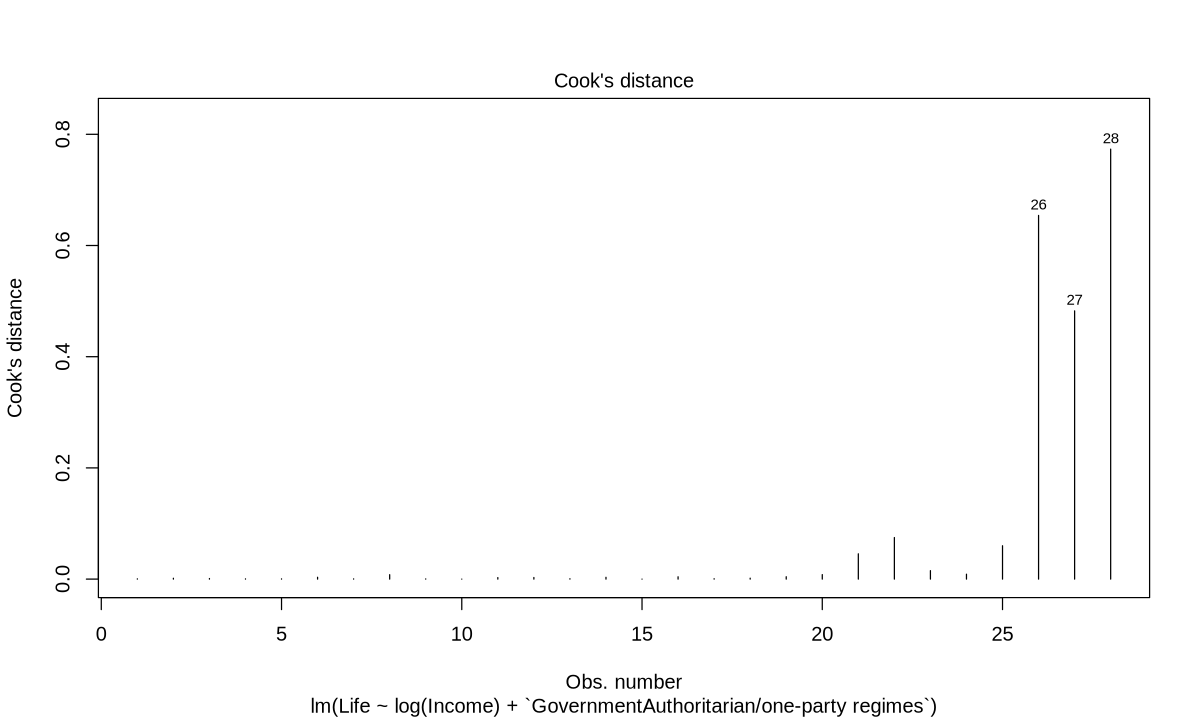

In [51]:
plot(fit_final, which=4)

Cook's distance gives us some insights about outliers in our data. Visually and considering cook's distance we can expect, that we have at least two outliers in our data.

Now lets analyze homoskedasticity of residuals:

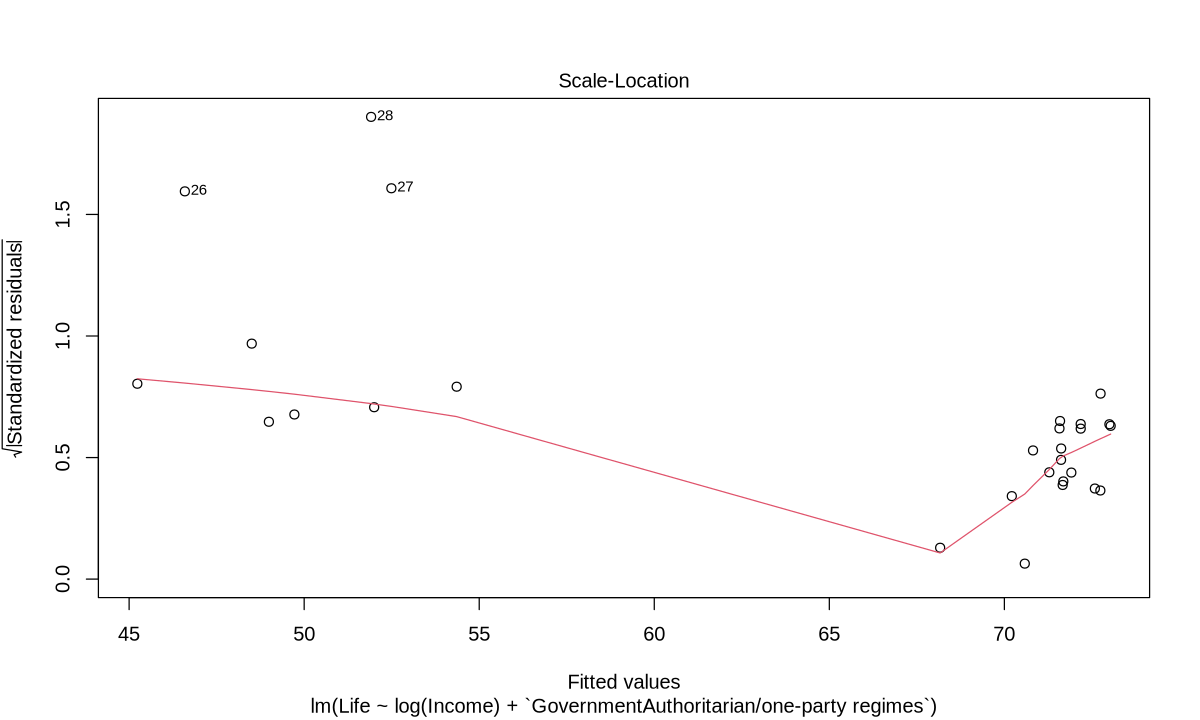

In [52]:
plot(fit_final, which=3)

In [53]:
ols_test_breusch_pagan(fit_final)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

              Data               
 --------------------------------
 Response : Life 
 Variables: fitted values of Life 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    20.98749 
 Prob > Chi2   =    4.622917e-06 

p-value is far less than alpha, we reject the null hypothesis in preference of alternative that the variance of residuals is not constant.

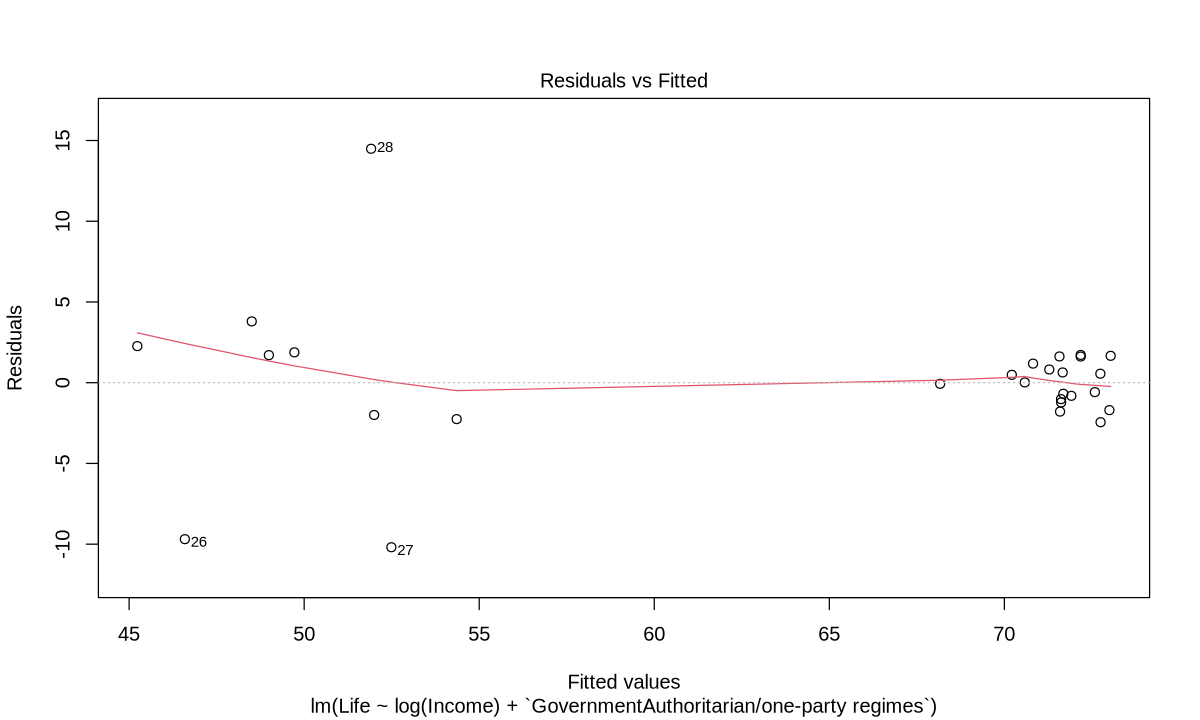

In [54]:
plot(fit_final, which=1)

## References
1. ex0327: Life Expectancy and Per Capita Income, Leinhardt, S. and Wasserman, S.S. (1979). Teaching Regression: An Exploratory Approach, The American Statistician 33(4): 196--203., https://www.rdocumentation.org/packages/Sleuth2/versions/2.0-7/topics/ex0327
2. Per Capita Income, Wikipedia, https://en.wikipedia.org/wiki/Per_capita_income
3. Industrial countries, A Dictionary of Economics, https://www.oxfordreference.com/display/10.1093/oi/authority.20110803100002206
4. OPEC, Wikipedia, https://en.wikipedia.org/wiki/OPEC